In [1]:
%reload_ext autoreload

%autoreload 2

In [2]:
input_file = "../../test_data/system_tests/Spectronaut_LargeFC/re_run_SN15/20220607_153923_MP-LFC-MS1var-OT-S1-120kMS1_Report.tsv.spectronaut_fragion_isotopes.aq_reformat.tsv"
directlfq_file = "../../test_data/system_tests/Spectronaut_LargeFC/re_run_SN15/20220607_153923_MP-LFC-MS1var-OT-S1-120kMS1_Report.tsv.protein_intensities.tsv"

spectronaut_protein_intensities = "../../test_data/system_tests/Spectronaut_LargeFC/re_run_SN15/20220607_153923_MP-LFC-MS1var-OT-S1-120kMS1_Report.tsv.spectronaut_protein.aq_reformat.tsv"
iq_protein_intensities = "../../test_data/system_tests/Spectronaut_LargeFC/re_run_SN15/spectronaut_largefc_set_iq-MaxLFQ-fast.txt"


protein_mapping_file = "../../test_data/system_tests/Spectronaut_LargeFC/re_run_SN15/organism_map.tsv"
samplemap  = "../../test_data/system_tests/Spectronaut_LargeFC/re_run_SN15/samplemap.tsv"

benchmark_figure = "../../test_data/system_tests/Spectronaut_LargeFC/re_run_SN15/benchmark_figure.pdf"

run_directlfq = False

In [3]:
if run_directlfq:
    import directlfq.lfq_manager as lfqmgr

    lfqmgr.run_lfq(input_file=input_file)


In [4]:
import directlfq.benchmarking as lfqbenchmark
import directlfq.utils as lfqutils


samples_used = lfqutils.get_samples_used_from_samplemap_file(samplemap, cond1="S1", cond2="S2")





restable_directlfq = lfqbenchmark.ResultsTableDirectLFQ(input_file=directlfq_file, input_name="directLFQ", samples_c1=samples_used[0], samples_c2=samples_used[1])
restable_iq = lfqbenchmark.ResultsTableIq(input_file=iq_protein_intensities, input_name="iq", samples_c1=samples_used[0], samples_c2=samples_used[1])

restable_spectronaut = lfqbenchmark.ResultsTableDirectLFQ(input_file=spectronaut_protein_intensities, input_name="Spectronaut", samples_c1=samples_used[0], samples_c2=samples_used[1])

/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:153: RuntimeWarning: divide by zero encountered in log2
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]
/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:153: RuntimeWarning: invalid value encountered in double_scalars
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]
/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:153: RuntimeWarning: divide by zero encountered in log2
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]
/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:

In [5]:
organism_annotator_spectronaut_based = lfqbenchmark.OrganismAnnotatorSpectronaut(mapping_file=protein_mapping_file,protein_column="PG.ProteinGroups", organism_column="PG.Organisms")
organism_annotator_spectronaut_based.annotate_table_with_organism(restable_directlfq)
organism_annotator_spectronaut_based.annotate_table_with_organism(restable_spectronaut)
organism_annotator_spectronaut_based.annotate_table_with_organism(restable_iq)


In [12]:
import seaborn as sns
import directlfq.visualizations as lfq_viz

class MultiOrganismMultiMethodBoxPlotAdapted(lfq_viz.MultiOrganismMultiMethodBoxPlot):
    def plot_boxplot(self):
        color_palette = sns.color_palette(self._colorlist_hex, n_colors=len(self._fcs_to_expect))
        sns.violinplot(data=self._method_ratio_results_table, x="method", y = "log2fc", hue= "organism", palette=color_palette, hue_order=self._organisms_to_plot, ax=self.ax, linewidth=0.8)


In [13]:
class MultiOrganismIntensityFCPlotter():
    def __init__(self, ax, resultstable_w_ratios, organisms_to_plot = None, fcs_to_expect = None, title = ""):
        print('init MultiOrganismIntensityFCPlotter')
        self.ax = ax
        self._color_list_hex = ['#ffd479', '#325e7a', '#bad566']
        self._resultstable_w_ratios = resultstable_w_ratios
        self._organism_column = resultstable_w_ratios.organism_column
        self._log2fc_column = resultstable_w_ratios.log2fc_column
        self._mean_intensity_column = resultstable_w_ratios.mean_intensity_column
        
        self._organisms_to_plot = self._get_organisms_to_plot(organisms_to_plot)
        self._fcs_to_expect = fcs_to_expect

        self._title = self._get_title(title)
        self._scatter_per_organism()
        self._add_expected_lines()

    def _get_organisms_to_plot(self, organisms_to_plot):
        if organisms_to_plot is not None:
            return organisms_to_plot
        else:
            return sorted(list(set(self._resultstable_w_ratios.formated_dataframe[self._organism_column].astype('str'))))
    
    def _get_title(self, title):
        if title !="":
            self._print_infos_about_data()
            return title
        return self._generate_title()

    def _print_infos_about_data(self):
        for organism in self._organisms_to_plot:
            subtable_organism = self._get_organism_subtable(organism)
            print(self._get_stats_of_organism(organism, subtable_organism))

    def _generate_title(self):
        for organism in self._organisms_to_plot:
            subtable_organism = self._get_organism_subtable(organism)
            title += self._get_stats_of_organism(organism, subtable_organism)
        return title

    def _scatter_per_organism(self):
        complete_table = self._resultstable_w_ratios.formated_dataframe.copy()
        complete_table[self._mean_intensity_column] = np.log2(complete_table[self._mean_intensity_column])
        complete_table = self._remove_omitted_organisms_from_table(complete_table)
        color_palette = sns.color_palette(self._color_list_hex, n_colors=len(self._organisms_to_plot))
        sns.scatterplot(data= complete_table, x =self._mean_intensity_column, y= self._log2fc_column, hue=self._organism_column, alpha=0.15, ax=self.ax, 
        hue_order=self._organisms_to_plot, palette=color_palette, size=0.2)
        self.ax.set_title(self._title)
    
    def _remove_omitted_organisms_from_table(self, complete_table):
        row_w_permitted_organism = [x in self._organisms_to_plot for x in complete_table["organism"]]
        return complete_table[row_w_permitted_organism]

    def _add_expected_lines(self):
        if self._fcs_to_expect is not None:
            for idx, fc in enumerate(self._fcs_to_expect):
                color = self._color_list_hex[idx]
                self.ax.axhline(fc, color = color)

    def _get_organism_subtable(self, organism):
        complete_table = self._resultstable_w_ratios.formated_dataframe
        return complete_table[complete_table[self._organism_column] == organism]
    
    def _get_stats_of_organism(self, organism, subtable_organism):
        fcs = subtable_organism[self._log2fc_column].to_numpy()
        fcs = fcs[np.isfinite(fcs)]
        median_fc = np.nanmedian(fcs)
        std_fc = np.nanstd(fcs)
        num_ratios = sum(~np.isnan(fcs))
        return f"{organism} num:{num_ratios} median_FC:{median_fc:.2} STD:{std_fc:.2}\n"

Saccharomyces cerevisiae (strain ATCC 204508 / S288c) num:1412 median_FC:0.99 STD:0.21

Homo sapiens num:3591 median_FC:0.029 STD:0.14

Caenorhabditis elegans num:2067 median_FC:-0.31 STD:0.15

Saccharomyces cerevisiae (strain ATCC 204508 / S288c) num:1422 median_FC:0.96 STD:0.26

Homo sapiens num:3599 median_FC:-0.061 STD:0.15

Caenorhabditis elegans num:2071 median_FC:-0.42 STD:0.18

Saccharomyces cerevisiae (strain ATCC 204508 / S288c) num:1411 median_FC:1.0 STD:0.31

Homo sapiens num:3591 median_FC:0.038 STD:0.16

Caenorhabditis elegans num:2067 median_FC:-0.32 STD:0.22



/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


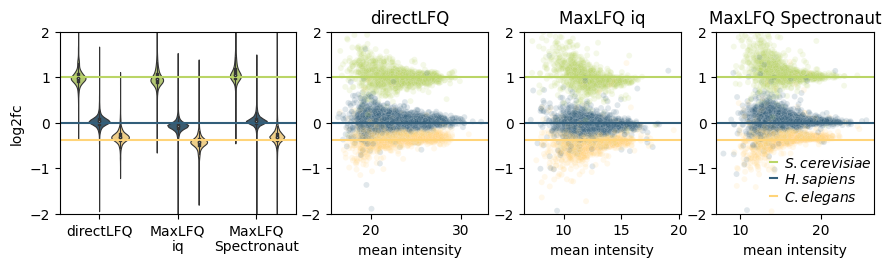

In [14]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import directlfq.benchmarking




methodname2resultsdf = {'directLFQ' : restable_directlfq.formated_dataframe, 'MaxLFQ\niq' : restable_iq.formated_dataframe, 'MaxLFQ\nSpectronaut' : restable_spectronaut.formated_dataframe}

a4_dims = (11.7, 8.27)
a4_width_no_margin = 10.5
fig, axes = plt.subplots(1, 4,figsize=(a4_width_no_margin,2.363 ), gridspec_kw={'width_ratios' : [1.5, 1, 1, 1]})

organisms_to_plot = [ "Saccharomyces cerevisiae (strain ATCC 204508 / S288c)", "Homo sapiens", "Caenorhabditis elegans"]
fcs_to_expect = [  np.log2(2), 0, -np.log2(1.3)]

merged_table = directlfq.benchmarking.ResultsTableMerger(method_name2results_df=methodname2resultsdf).merged_table


MultiOrganismMultiMethodBoxPlotAdapted(method_ratio_results_table=merged_table, ax = axes[0], organisms_to_plot=organisms_to_plot,fcs_to_expect= fcs_to_expect)



fcplotter_directLFQ = directlfq.benchmarking.MultiOrganismIntensityFCPlotter(ax=axes[1], resultstable_w_ratios=restable_directlfq, organisms_to_plot = organisms_to_plot, fcs_to_expect= fcs_to_expect, title="directLFQ")

fcplotter_maxLFQiq = directlfq.benchmarking.MultiOrganismIntensityFCPlotter(ax=axes[2], resultstable_w_ratios= restable_iq, organisms_to_plot = organisms_to_plot,  fcs_to_expect= fcs_to_expect, title= "MaxLFQ iq")
fcplotter_maxLFQspect = directlfq.benchmarking.MultiOrganismIntensityFCPlotter(ax=axes[3], resultstable_w_ratios= restable_spectronaut, organisms_to_plot = organisms_to_plot,  fcs_to_expect= fcs_to_expect, title= "MaxLFQ Spectronaut")



for ax in axes:
    ax.get_legend().remove()

for ax in axes[1:]:
    ax.set_ylabel("")

for ax in axes:
    ax.set_xlabel("mean intensity")
axes[0].set_xlabel("")
axes[0].set_ylim([-2, 2])
# axes[0].set_ylim([15, 33])
axes[1].set_ylim([-2, 2])
# axes[1].set_ylim([17, 35])
axes[2].set_ylim([-2, 2])

axes[3].set_ylim([-2, 2])

lines = axes[1].get_lines()
#axes[1].legend(lines, ["S. cerevisiae", "H. sapiens", "C. elegans"], loc='upper left', bbox_to_anchor=(1, 1))
fig.legend(lines, ["$S. cerevisiae$", "$H. sapiens$", "$C. elegans$"], bbox_to_anchor=[0.85, 0.25], 
           loc='center', ncol=1, title = None, frameon = False, labelspacing = 0, handlelength = 0.5, handletextpad = 0.5)
#change label type in legend



#fig.tight_layout()

fig.savefig(benchmark_figure, bbox_inches="tight", dpi=300)
fig.savefig(benchmark_figure.replace(".pdf", ".png"),  bbox_inches="tight", dpi=300)